In [ ]:
## Mount Google Drive Data (If using Google Colaboratory)
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
except:
    print("Mounting Failed.")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


The main idea is to ulitize seq2seq, or more specifically encoder-decoder structure. We first encode the image into (num_layer, batch_size, hidden_size), so that the output of the encoder layer can be seen as a hidden state for either LSTM or GRU. For LSTM, the encoder output should be two becuase LSTM has two input (h, c). For GRU we only need one. Considering the running time, complexity and google colab compute units. We are using GRU with single hidden_layer.

Here we also add attention machanism to reduce the burden of encoder. Instead of only use the last encoder hidden state, we use additive attention to find the most relavant hidden state in encoder. (Notice that we can try dot product attention in paper Attention Is ALL You Need.) We assume that Additive attention will get higher accuarcy because it involves learning parameters (weights)

## Image Captioning Model with Pretrained CNN + Attentioned GRU

In [ ]:
import torch.nn as nn
import torchvision.models as models
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_

import collections
import re
import pandas as pd
import random 
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

from PIL import Image
from torchvision.transforms import transforms
from torchvision.models import resnet50, ResNet50_Weights

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


## Data Load and Transform

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Image Captioning/Flickr8k/captions.txt')
df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [ ]:
print('total number of unique image: ', len(df['image'].unique()))
print('total number of df: ', len(df))

## plan to use 6091 for training, 1000 for val and 1000 for test

## [0:6091*5 = 30455 ] traing
## [30455:35455,:] val
## [35355: , :] test

total number of unique image:  8091
total number of df:  40455


In [ ]:
df_train = df.iloc[:30455, :].reset_index()
df_val = df.iloc[30455:35455,:].reset_index()
df_test= df.iloc[35455:,:].reset_index()

print(len(df_train))
print(len(df_val))
print(len(df_test))

30455
5000
5000


In [ ]:
class Vocab:
    def __init__(self, tokens = None, minimum_frequency = 0 , reserved_tokens = None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []

        if len(tokens) == 0 or isinstance(tokens, list):
            tokens = [token for line in tokens for token in line]
            counter = collections.Counter(tokens)
        else:
            raise Exception('tokens should be a list of list')

        self._token_frequence = sorted(counter.items(), key = lambda x: x[1], reverse = True)

        self.index_to_token = ['<UNK>'] + reserved_tokens 
        self.token_to_index = {token: index for index , token in enumerate(self.index_to_token)}

        for token , frequency in self._token_frequence: 
            if frequency < minimum_frequency:
                # because we have already sorted the dictionary in decreasing order
                break

            if token not in self.token_to_index:
                self.index_to_token.append(token)
                self.token_to_index[token] = len(self.index_to_token) - 1

    def __len__(self):
        return len(self.index_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_index.get(tokens, 0) # 0 is the index for <UNK>
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.index_to_token[indices]

        return [self.index_to_token[index] for index in indices]


## Create vocabulary here

In [ ]:
tokens = [line.lower().split() for line in df.caption.tolist()]
reserved_tokens = ['<BOS>','<EOS>','<PAD>']
minimum_frequency = 1
vocab = Vocab(tokens,minimum_frequency,reserved_tokens)

In [ ]:
class Flickr8kDataset(Dataset):
    def __init__(self, image_path, transform = None, df = None, vocab = None):
        self.image_path = image_path
        self.transform = transform

        self.df = df

        self.img = self.df['image']
        self.caption = self.df['caption']
        self.vocab = vocab
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        image = self.img[index]
        caption = self.caption[index]

        image = Image.open(os.path.join(self.image_path, image)).convert('RGB')

        if self.transform != None:
            image = self.transform(image)

        token = caption.lower().split()

        #return image, torch.tensor([self.vocab['<BOS>']] + self.vocab[token] + [self.vocab['<EOS>']])
        return image, torch.tensor( self.vocab[token] + [self.vocab['<EOS>']])

## Create traindata set, validation dataest and test dataset

In [ ]:
class Mycollate():
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self,batch):
        images = [i[0].unsqueeze(0) for i in batch] #batch is image and caption -> image = batch[0], caption = batch[1]
        images = torch.cat(images, dim = 0)

        targets = [i[1] for i in batch]
        targets = pad_sequence(targets, batch_first = True, padding_value = self.pad_idx)

        return images, targets

In [ ]:
image_path = '/content/gdrive/MyDrive/Colab Notebooks/Image Captioning/Flickr8k/Images'
caption_path = "/content/gdrive/MyDrive/Colab Notebooks/Image Captioning/Flickr8k/captions.txt"

transform = transforms.Compose([
    transforms.Resize(232),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # transforms.GaussianBlur(3)
])


train_dataset = Flickr8kDataset(image_path, transform = transform, df = df_train, vocab = vocab)
val_dataset = Flickr8kDataset(image_path, transform = transform,  df = df_val, vocab = vocab )

print(len(train_dataset), len(val_dataset))

pad_idx = vocab['<PAD>']

train_dataloader = DataLoader(
      dataset = train_dataset,
      batch_size = 64,
      num_workers = 4,
      shuffle = True,
      pin_memory = True,
      collate_fn = Mycollate(pad_idx = pad_idx)
  )

val_dataloader = DataLoader(
      dataset = val_dataset,
      batch_size = 32,
      num_workers = 2,
      pin_memory = True,
      collate_fn = Mycollate(pad_idx = pad_idx)
  )

30455 5000


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Model Create CNN and RNN

In [ ]:
# resnet18 = torch.hub.load("pytorch/vision", "resnet18", weights="IMAGENET1K_V1")

# here we using pretrained resnet 50
resnet50 = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
for param in resnet50.parameters():
    param.requires_grad = False

In [ ]:
class encoderCNN(nn.Module):
    ## since we are using the pretrained resnet image input (batch_size, 3, 224, 224)
    ## output size: (hidden_layer = 1, batch_size, hidden_size)
    def __init__(self, hidden_size):
        super(encoderCNN, self).__init__()
        self.resnet = resnet50 #use pretrained resnet50
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        features = self.resnet(x)
        
        output = self.dropout(self.relu(features)) #[batchsize, hidden_size]

        return output.unsqueeze(0) # [hidden_layer = 1, batchsize, hidden_size]

In [ ]:
!pip install -q torchinfo

from torchinfo import summary

In [ ]:
summary(model=encoderCNN(256),
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
encoderCNN (encoderCNN)                       [32, 3, 224, 224]    [1, 32, 256]         --                   Partial
├─ResNet (resnet)                             [32, 3, 224, 224]    [32, 256]            --                   Partial
│    └─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
│    └─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
│    └─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
│    └─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
│    └─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 5

In [ ]:
#We use Bahdanau (Additive Addention) since it has learned weight. 

#Key and Value is the encoder output: here we have [1, batchsize, hidden_size]

#Query is the last decoder output: [1, batchsize, hidden_size]

#Output is [1, batchsize, hidden_size]

class AdditiveAttention(nn.Module):
  def __init__(self, key_dim, query_dim, num_hiddens):
    super(AdditiveAttention, self).__init__()
    self.W_k = nn.Linear(key_dim, num_hiddens)
    self.W_q = nn.Linear(query_dim, num_hiddens)
    self.W_v = nn.Linear(num_hiddens, 1)
    self.softmax = nn.Softmax(dim = 1)

  def forward(self, query, key, value):
    query = self.W_q(query) #[1, batch_size, num_hiddens]
    key = self.W_k(key)     #[1, batch_size  num_hiddens]
    value = self.W_k(value) #[1, btach_size, num_hiddens]

    output = torch.tanh(query + key)     #[1, batch_size, num_hiddens]

    weight = self.softmax(self.W_v(output)) #[1, batch_size, 1] 

    # want to perform batch matrix multiplication 
    weight = weight.permute(1,0,2) #[batch, 1, 1]
    value = value.permute(1,0,2)   #[batch, 1, hiddens]

    return torch.bmm(weight, value).permute(1,0,2)   # [1, batch_size, num_hiddens]

    
    

In [ ]:
class decoderAttentionRNN(nn.Module): # put encoder into decoder input
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, dropout):
        super(decoderAttentionRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.attention = AdditiveAttention(hidden_size, hidden_size, hidden_size)
        self.rnn = nn.GRU(embed_size + hidden_size, hidden_size, num_layers, dropout = dropout)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, X, state):
        # X shape [batch_size, sequence_length]
        # state shape [hidden_layer = 1, batch_size, hidden_size]
        
        X = self.embedding(X)  # [batch_size, squence_lengh, embed_size]
        X = X.permute(1, 0, 2) # [squence_lengh, batch_size, embed_size]

        encoder_output = state  #[1, batch_size, hidden_size]
                
        state = torch.ones((1, encoder_output.shape[1], encoder_output.shape[2])).to(device)

        output_list = []

        for x in X:
          # x [bacth_size, embed_size]
          query = state[-1].unsqueeze(0) #[1, batch_size, hidden_size] 
          context = self.attention(query, encoder_output, encoder_output) #context: [1, batchsize, hidden_size]
          x = torch.cat( ( x.unsqueeze(0), context), dim = 2) #[1, batchsize, embed_size + hidden_size]

          outputs, state = self.rnn(x, state)
          #outputs : [sequence_length = 1, batchsize, embed_size]
          output_list.append(outputs)

        output = self.linear(torch.cat(output_list, dim = 0)).permute(1,0,2) #[batchsize, sequence_length, vocab_size]
        return output, state
       


In [ ]:
class CNN2RNN(nn.Module):
    def __init__(self, embed_size, vocab_size, hidden_size, num_layers, dropout):
        super(CNN2RNN, self).__init__()
        self.encoderCNN = encoderCNN(hidden_size)
        self.decoderAttentionRNN = decoderAttentionRNN(vocab_size, embed_size, hidden_size, num_layers, dropout)

    def forward(self, images, caption):
        # images [batchsize, C = 3, H = 224, W = 224]
        # Caption [batchsize, sequence_length]
        # Output [batch_size, squence_lengh, vocab_size]

        encoder_output = self.encoderCNN(images) #[num_layer = 1, batchsize, hidden_size]

        # We concate the <bos> token to the begin of the sentence so that
        # the model will learn how to predict next words start with <bos>
        # this will help us to do further inference

        bos = torch.tensor([vocab['<BOS>']] * caption.shape[0], device = device).reshape(-1,1)
        caption = torch.cat( (bos, caption[:,:-1]), dim = 1)


        output, state = self.decoderAttentionRNN(caption, encoder_output)
        return output  

## Model Check Finished

In [ ]:
def save_checkpoint(state, filename = "./my_checkpoint2.pth.tar"):
    print("Checkpoint saved")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model, optimizer):
    print("Checkpoint loaded")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    return model, optimizer

In [ ]:
load_model = False
save_model = False

# Model Parameter
embed_size = 256
vocab_size = len(vocab)
hidden_size = 256
num_layers = 1
dropout = 0.5
model = CNN2RNN(embed_size=embed_size, hidden_size=hidden_size,vocab_size=vocab_size, num_layers=num_layers, dropout = dropout).to(device)

# loss and optimazation
learning_rate = 3e-4
loss_criterion = nn.CrossEntropyLoss(ignore_index=train_dataset.vocab["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# training epochs
num_epochs = 20

print(device)


cuda


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [ ]:
if load_model:
    step = load_checkpoint(torch.load("my_checkpoint.pth.tar"), model, optimizer)

In [ ]:
from collections import defaultdict
test_dic = defaultdict(list)

for i in range(len(df_test)):
  img = df_test.iloc[i,:]['image']
  caption = df_test.iloc[i,:]['caption']
  test_dic[img].append(caption)

In [ ]:
!pip install torchmetrics

from torchmetrics.functional import bleu_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def greedy_predict(model, img, vocab, device, max_length):

    with torch.no_grad():
      encoder_output = model.encoderCNN(img) #[1, batchsize, hiddensize]
      X = torch.tensor([vocab['<BOS>']], device = device).unsqueeze(dim = 0)
      #X shape: [1,1] two dimension (start with BOS)

      result = []
      state = encoder_output # [1, batch_size, embed_size]
      
      for _ in range(max_length):
          output, state = model.decoderAttentionRNN(X, state) 
          #output shape: [squence_lengh = 1, batch_size = 1, vocab_size]
          #state  shape [num_layer = 1, batchsize, embed_size]
          #output = nn.Softmax(dim=2)(output)
          X = output.argmax(dim = 2) 
          # X shape: [batch_size = 1, sequence_length = 1]
          prediction = X.squeeze(0).item()
          if prediction == vocab['<EOS>']:
              break
          
          result.append(prediction)

      return ' '.join(vocab.to_tokens(result))

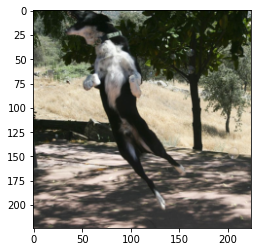

greedy search:  perplexed touching source fastens perplexed touching source fastens perplexed touching source fastens perplexed touching source fastens perplexed touching source fastens


In [ ]:
def inference_(df_test):
  image_path = '/content/gdrive/MyDrive/Colab Notebooks/Image Captioning/Flickr8k/Images'

  transform = transforms.Compose([
      transforms.Resize(232),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
      # AddGaussianNoise(0,1)
  ])

  for i in df_test['image'].sample(n=1).tolist():
    image = Image.open(os.path.join(image_path, i)).convert('RGB')
    image = transform(image)
    image2 = image
    image2[0] = image2[0] * 0.229
    image2[1] = image2[1] * 0.224 
    image2[2] = image2[2] * 0.225 
    image2[0] += 0.485 
    image2[1] += 0.456 
    image2[2] += 0.406
    plt.imshow(image2.permute(1,2,0))
    plt.show()
    image = image.unsqueeze(0)
    image = image.to(device)

    print('greedy search: ', greedy_predict(model, image, vocab, device, max_length = 20))

inference_(df_test)

In [ ]:
model.train() 

best_eval_loss = 10000
val_interval = 1

train_loss_list = []
val_loss_list = []

for epoch in range(num_epochs):
    print('epoch: ', epoch+1)
    checkpoint = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}
    save_checkpoint(checkpoint, filename = '/content/gdrive/MyDrive/Colab Notebooks/Image Captioning/cnn_attention_only.pth.tar')

    total_train_loss = 0
    step = 0

    for idx, (imgs, captions) in tqdm(enumerate(train_dataloader), total=len(train_dataloader), leave=False):
        step += 1
        imgs = imgs.to(device)
        captions = captions.to(device)

        output = model(imgs, captions) 
        optimizer.zero_grad()

        # captions shape: [batch_size ,sequence_length]
        # output.shape : [batch_size, sequence_length, vocab_size]
        # loss entropy loss:
            # input: (N, C)
            # output: (N)
        loss = loss_criterion(output.reshape(-1, output.shape[2]), captions.reshape(-1))

        total_train_loss += loss.item()
        
        loss.backward()

        # CLIPPING Method
        clip_grad_norm_(model.parameters(), 5)
        
        optimizer.step()
        
    total_train_loss = total_train_loss / step
    train_loss_list.append(total_train_loss)
    print('Train loss: {}'.format(total_train_loss))
    
    
    ## for inference
    inference_(df_test)
    ##print(sentence_predict(model, test_image, vocab, device, max_length = 30))

    val_total_loss = 0
    val_step = 0

    if (epoch + 1) % val_interval == 0:

      with torch.no_grad():
        for idx, (imgs, captions) in tqdm(enumerate(val_dataloader), total=len(val_dataloader), leave=False):
          val_step += 1
          imgs = imgs.to(device)
          captions = captions.to(device)

          output = model(imgs, captions) 
          loss = loss_criterion(output.reshape(-1, output.shape[2]), captions.reshape(-1))

          val_total_loss += loss.item()        
          
        val_total_loss = val_total_loss / val_step
        val_loss_list.append(val_total_loss)
        print('val loss: {}'.format(val_total_loss))

      if val_total_loss < best_eval_loss:
        checkpoint = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}
        save_checkpoint(checkpoint, filename = '/content/gdrive/MyDrive/Colab Notebooks/Image Captioning/CNN_BEST_Attention_GRU.pth.tar')



Output hidden; open in https://colab.research.google.com to view.

In [ ]:
with open('/content/gdrive/MyDrive/Deep_Learning/Image Captioning/CNN_Attention_GRU_Train.txt', 'a') as testwritefile_train:
  for index, i in enumerate(train_loss_list):
    testwritefile_train.write('step :{}, loss score: {}\n'.format(index,i))

with open('/content/gdrive/MyDrive/Deep_Learning/Image Captioning/CNN_Attention_GRU_Val.txt', 'a') as testwritefile_val:
  for index, i in enumerate(val_loss_list):
    testwritefile_val.write('step :{}, loss score: {}\n'.format(index,i))

FileNotFoundError: ignored

In [ ]:
model = CNN2RNN(embed_size=embed_size, hidden_size=hidden_size,vocab_size=vocab_size, num_layers=num_layers, dropout = dropout).to(device)
model.load_state_dict(torch.load('/content/gdrive/MyDrive/Colab Notebooks/Image Captioning/CNN_BEST_Attention_GRU.pth.tar')['state_dict'])

In [ ]:
def inference(df_test):
  image_path = '/content/gdrive/MyDrive/Colab Notebooks/Image Captioning/Flickr8k/Images'

  transform = transforms.Compose([
      transforms.Resize(232),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])

  candidate_corpus_gp = []
  references_corpus = []

  for i in list(test_dic.keys()):
    test = [i.lower() for i in test_dic[i]]
    references_corpus.append(test)
    image = Image.open(os.path.join(image_path, i)).convert('RGB')
    image = transform(image)
    image = image.unsqueeze(0)
    image = image.to(device)

    gp = greedy_predict(model, image, vocab, device, max_length = 20)

    candidate_corpus_gp.append(gp)

    
  print('Greedy ')
  print(bleu_score(candidate_corpus_gp, references_corpus, n_gram=1))
  print(bleu_score(candidate_corpus_gp, references_corpus, n_gram=2))
  print(bleu_score(candidate_corpus_gp, references_corpus, n_gram=3))
  print(bleu_score(candidate_corpus_gp, references_corpus, n_gram=4))

In [ ]:
inference(df_test)